# Automatic Signature Stability Analysis And Verification Using Local Features

### Requirements :-
##### Libraries:-
* Numpy
* os
* Python 3.x
* matplotlib
* math
* mpl_toolkits.axes_grid1
* OpenCV 3.4.2.16
* Pickle

### To run this notebook successfully, please ensure the following steps.
* Ensure that all the libraries mentioned above are installed
* Ensure that in the current working directory the folder **Camera_calibration_data** and its entire folder structure exists and is maintained. **This is the input data to notebook.**



### Note:-
* ***If any of the steps are missing/files are missing, then some parts of the code may or may not work***
* It is advised to use the testing machine in "plugged in" mode, to avoid core suppression as happens in most modern PCs.
* ***To run this notebook, download `TrainingSet` and `TestSet` folders at notebook location and run the notebook***

#### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

#### Data Directories

In [2]:
tr_ref = './TrainingSet/Reference/'
test_ref = './TestSet/Reference/'

tr_genuine_sigs = './TrainingSet/Genuine/'
tr_disguise_sigs = './TrainingSet/Disguise/'
tr_sim_sigs = './TrainingSet/Simulated/'

test_query_sigs = './TestSet/Questioned/'

### Main Functions

In [3]:
def dist(a,b,mode='L2'):
    if mode == 'L2':
        return np.linalg.norm(a-b,axis = 1)
    
def surf_feat(path):
    surf_features = []
    surf_kps = []
    surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000,extended = 1)
    dirc = os.listdir(path)
    cnt = 0
    img_store = []
    for img in dirc:
        imgname = path+img
        if img[-4:] == '.png' or img[-4:]=='.PNG':
            tmp = cv2.imread(imgname, 0)
            img_store.append(tmp)
            kp, des = surf.detectAndCompute(tmp,None)
            surf_features.append(des)
            surf_kps.append(kp)
            cnt+=1
    surf_features = np.asarray(surf_features)
    surf_kps = np.array(surf_kps)
    stable_descs = []
    stable_kps = []
    unstable_kps = []
    for i in range(cnt):
        idxs = list(range(cnt))
        idxs.remove(i)
        features_loo = np.concatenate(surf_features[idxs])
        tot_dist = 0;
        dists = []
        for descs in surf_features[i]:
            min_dist = np.min(dist(features_loo,descs))
            tot_dist+=min_dist
            dists.append(min_dist)
        dist_avg = tot_dist/cnt
        stable_descs.extend(list(surf_features[i][np.where(dists<=dist_avg)]))
        stable_idx = np.where(dists<=dist_avg)[0]
        unstable_idx = np.where(dists>dist_avg)[0]
        stable_kps.append([surf_kps[i][j] for j in stable_idx])
        unstable_kps.append([surf_kps[i][j] for j in unstable_idx])
    
    for i in range(cnt):
        plt.figure(figsize = (8, 8), dpi = 60)
        tmp = cv2.drawKeypoints(img_store[i],stable_kps[i],None,color = (0,255,0))
        plt.imshow(tmp)
        plt.axis('off')
        plt.title('Stable Keypoints')
        plt.show()
    return np.array(stable_descs)

In [23]:
def classify(query_path, stable_descs, threshold = 0.11, batch_size = 'Full', num_plots = 5):
    queries = os.listdir(query_path)
    if batch_size is not 'Full':
        queries = queries[:batch_size]
    percentage_match = []
    for i, query_name in enumerate(queries):
        surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 1000,extended = 1)
        img = cv2.imread(query_path+query_name,  cv2.IMREAD_GRAYSCALE)
        kp, des = surf.detectAndCompute(img, None)
        tot_des = des.shape[0]
        matches = 0
        stable_kp = []
        unstable_kp = []
        itr=0
        pts = [[int(p.pt[0]), int(p.pt[1])] for p in kp]
        for desc in des:
            min_dist = np.min(dist(stable_descs,desc))
            if min_dist <= threshold:
                matches+=1
                stable_kp.append(pts[itr])
            else:
                unstable_kp.append(pts[itr])
            itr+=1
        stable_kp = np.asarray(stable_kp)
        unstable_kp = np.asarray(unstable_kp)
        if (i<num_plots):
            fig = plt.figure(figsize = (14,14), dpi = 60)
            ax = fig.add_subplot(121)
            ax1 = fig.add_subplot(122)
            ax.imshow(img,cmap = 'gray')
            ax1.imshow(img,cmap = 'gray')
            ax.scatter(stable_kp[:,0],stable_kp[:,1],color='green',label = 'stable')
            ax1.scatter(unstable_kp[:,0],unstable_kp[:,1],color='red',label='unstable')
            ax.axis('off')
            ax1.axis('off')
            ax.set_title('Stable')
            ax1.set_title('Unstable')
            plt.legend()
            plt.show()
        percentage_match.append(matches/tot_des)
    return np.array(percentage_match)

## Training

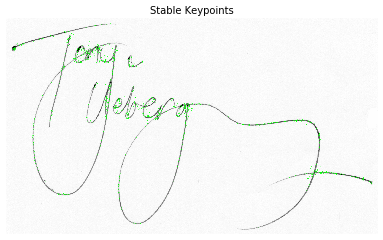

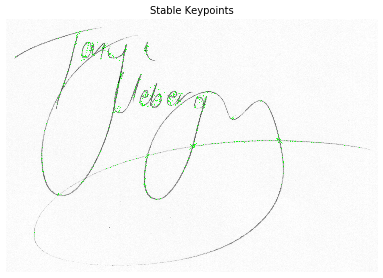

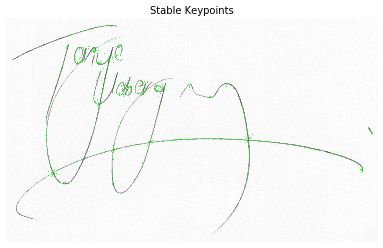

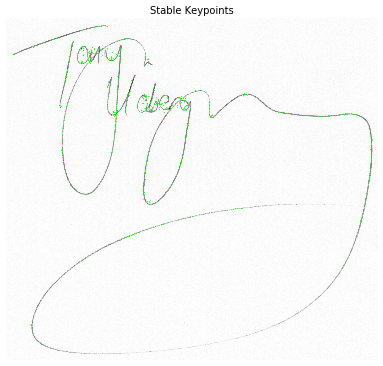

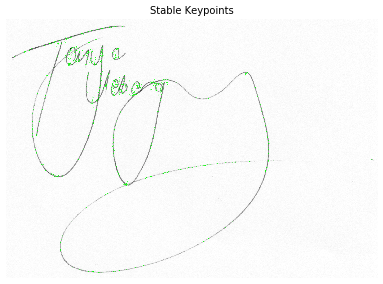

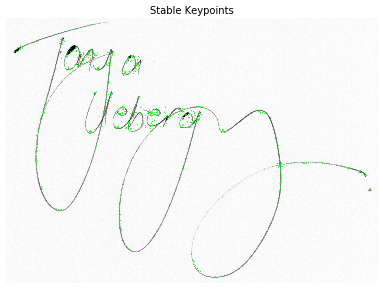

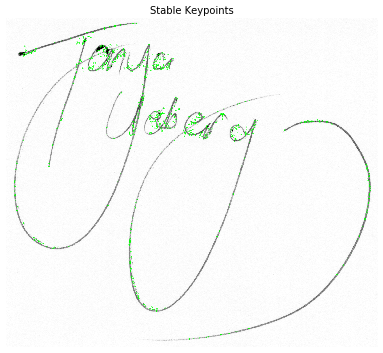

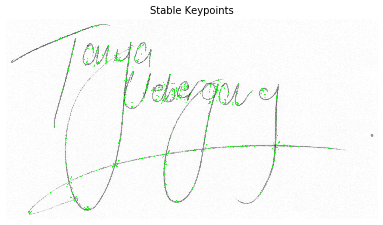

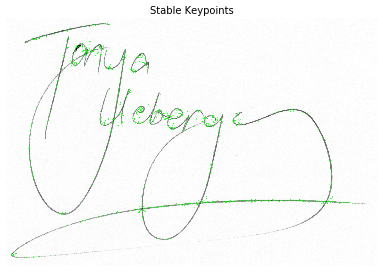

In [5]:
stable_kpt_from_refs = surf_feat(tr_ref)

Genuine Signatures


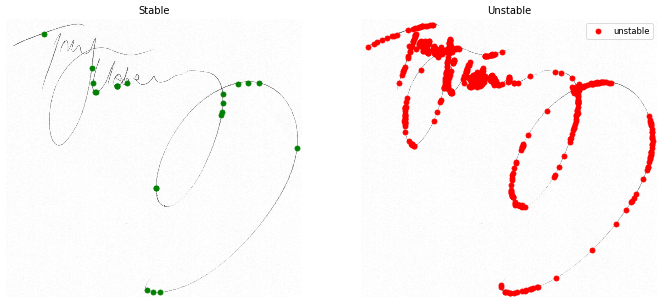

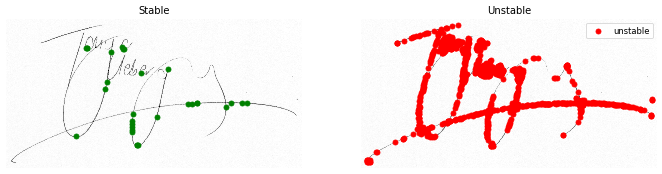

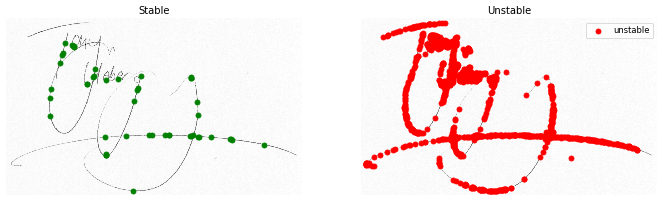

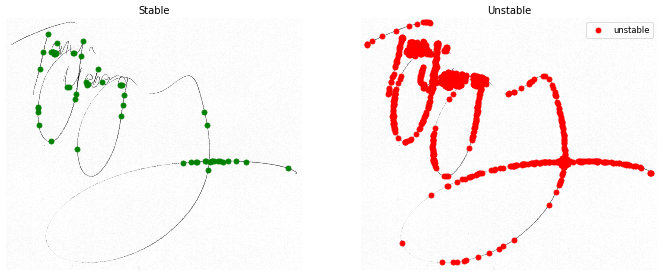

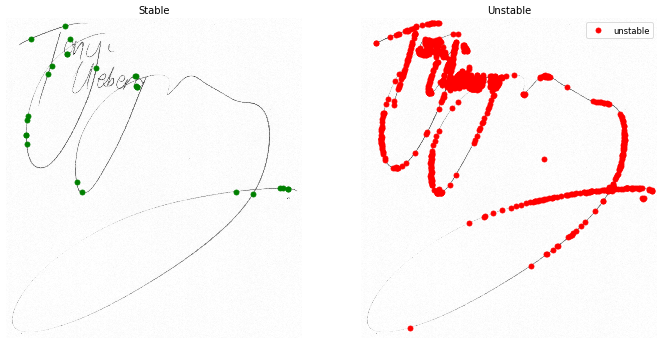

Disguised Signatures


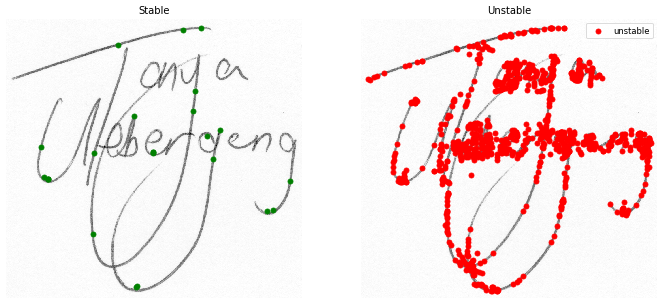

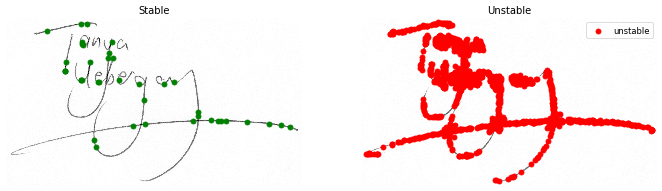

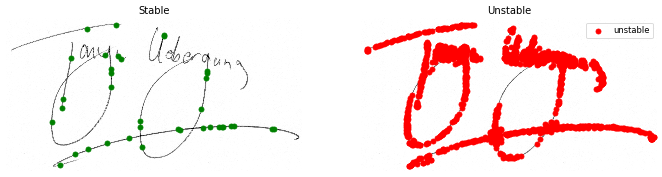

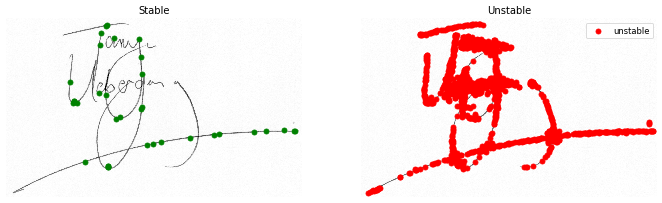

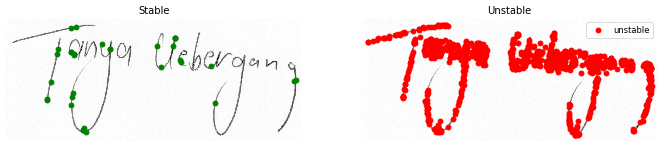

Simulated Signatures


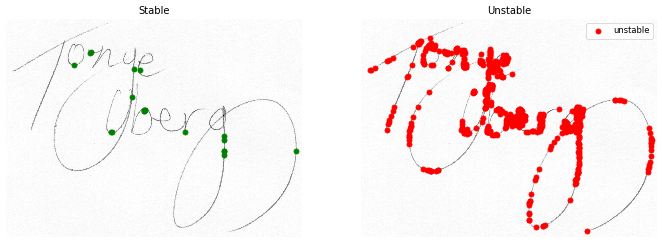

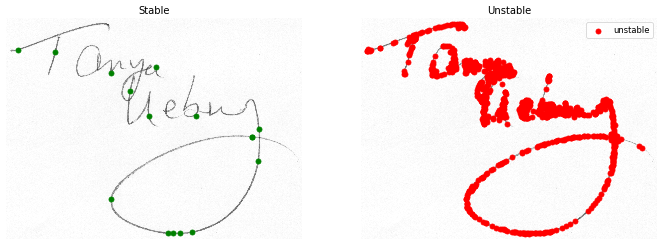

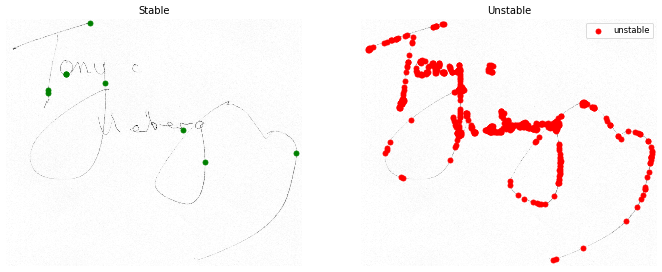

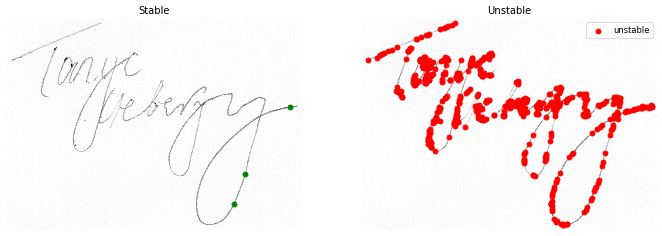

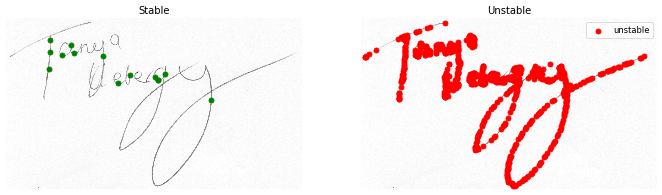

In [24]:
threshold = 0.11
print('Genuine Signatures')
genuine_matches = classify(tr_genuine_sigs, stable_kpt_from_refs, threshold)
print('Disguised Signatures')
disguise_matches = classify(tr_disguise_sigs, stable_kpt_from_refs, threshold)
print('Simulated Signatures')
sim_matches = classify(tr_sim_sigs, stable_kpt_from_refs, threshold)

### Saving Matched Stable keypoints

In [7]:
import pickle

In [8]:
file = open('./train_match_vals_'+str(threshold)+'.pkl','wb')
pickle.dump([genuine_matches, disguise_matches, sim_matches], file)
file.close
del file

In [29]:
far = []
frr = []
theta_range = np.arange(0.005, 0.05, 0.0005)
for theta in theta_range:
    gen = np.where(genuine_matches <= theta)
    disg = np.where(disguise_matches <= theta)
    sim = np.where(sim_matches > theta)
    frr.append((gen[0].shape[0] + disg[0].shape[0]) / (genuine_matches.shape[0] + disguise_matches.shape[0]) * 100)
    far.append(sim[0].shape[0] / sim_matches.shape[0] * 100)

In [19]:
def plot_matches(genuine_match, disguise_match, simulated_match, threshold, phase):

    plt.figure(figsize = (8, 8), dpi = 60)
    match = [genuine_match, disguise_match, simulated_match]
    plt.hist(match, label=['Genuine', 'Disguise', 'Simulated'])
    plt.legend()
    plt.title('Matched Points')
    plt.savefig('./match_points'+phase+'_' + str(threshold) + '.jpg')
    plt.show()

### Distribution of Training Set

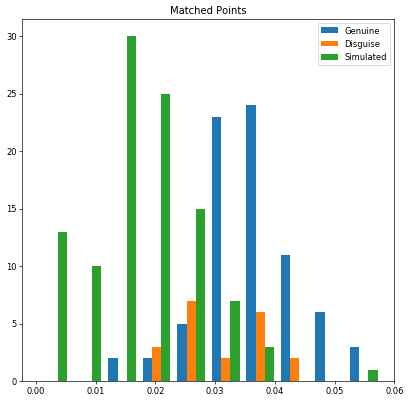

In [20]:
plot_matches(genuine_matches, disguise_matches, sim_matches, 0.11, 'train')

In [21]:
def plot_error(theta_range, far, frr, threshold):
    plt.figure(figsize = (8, 8))
    plt.plot(theta_range, far, color = 'red')
    plt.plot(theta_range, frr, color = 'blue')
#     idx=np.argwhere(np.diff(np.sign(y1 - y2 )) != 0).reshape(-1) + 0
    diff = np.abs(np.array(frr) - np.array(far))
    idx = np.where(diff == min(diff))[0][0]
    plt.scatter(theta_range[idx],(far[idx]+far[idx-1])/2, color = 'black', marker = 'o', s=50)
    print('EER = ',far[idx])
    plt.title('error rate')
    plt.legend(['FAR', 'FRR', 'EER'])
    plt.xlabel('Theta')
    plt.ylabel('Error rate')
    plt.savefig('./error_vs_theta' + str(threshold) + '.jpg')
    plt.show()
    del diff
    del idx

EER =  16.346153846153847


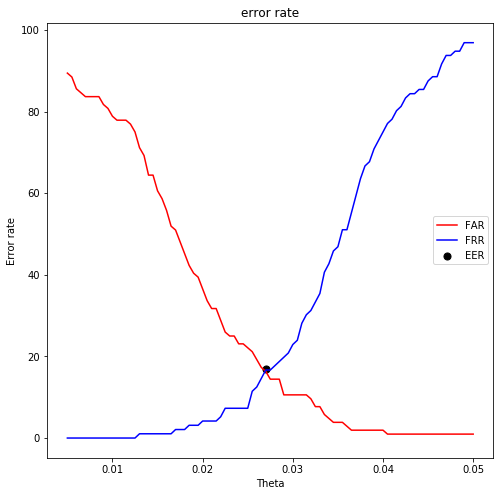

In [30]:
plot_error(theta_range, far, frr, 0.11)

In [36]:
eer = 0.0275
gen_conf = np.where(genuine_matches < eer)
disg_conf = np.where(disguise_matches < eer)
sim_conf = np.where(sim_matches > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_matches.shape[0] - gen_conf[0].shape[0]) + '\t' + str(gen_conf[0].shape[0]))
print('Disguise\t' + str(disguise_matches.shape[0] - disg_conf[0].shape[0]) + '\t' + str(disg_conf[0].shape[0]))
print('Simulated\t' + str(sim_conf[0].shape[0]) + '\t' + str(sim_matches.shape[0] - sim_conf[0].shape[0]))

		Genuine	Fake
Genuine		68	8
Disguise	12	8
Simulated	15	89


## Testing

*Displaying 5 samples with stable and unstable keypoints*

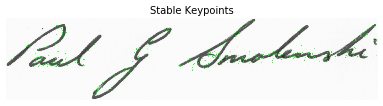

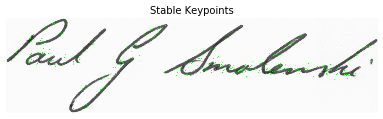

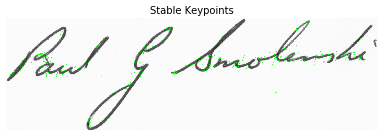

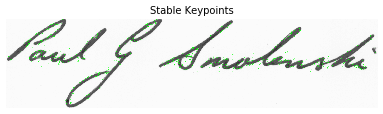

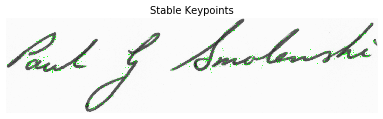

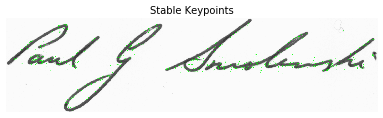

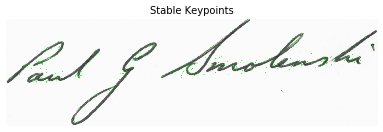

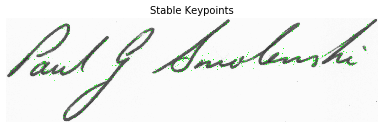

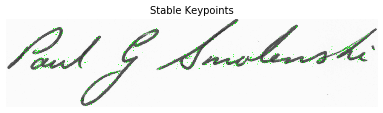

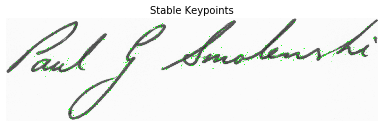

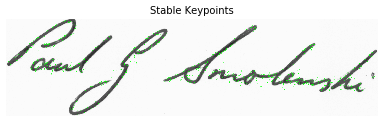

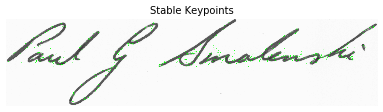

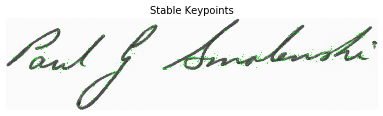

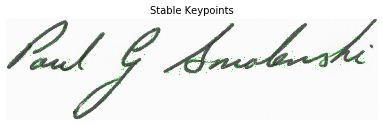

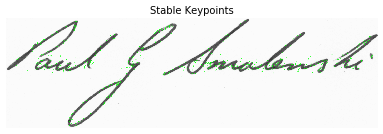

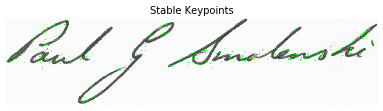

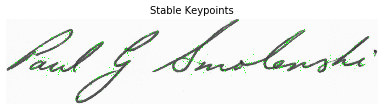

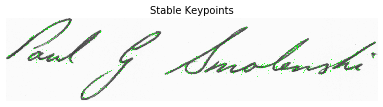

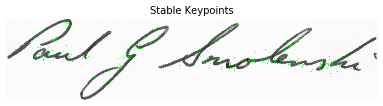

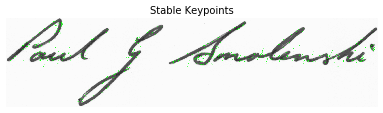

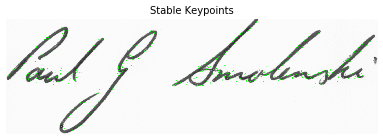

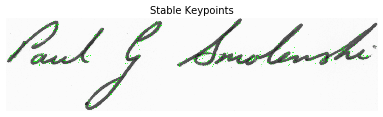

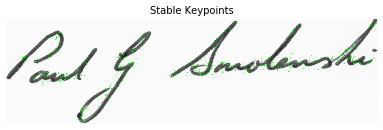

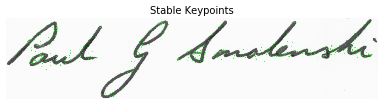

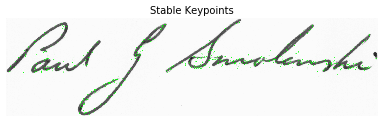

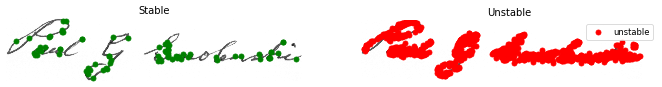

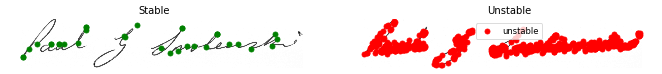

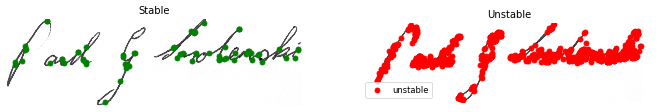

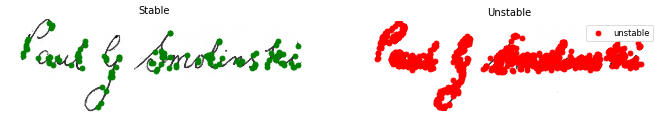

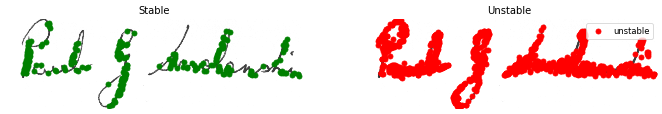

In [43]:
stable_kpt_from_test_refs = surf_feat(test_ref)
query_matches = classify(test_query_sigs, stable_kpt_from_test_refs)

In [44]:
file = open('./test_match_vals_'+str(threshold)+'.pkl','wb')
pickle.dump([query_matches], file)
file.close
del file

#### Verification with answer key provided with dataset

In [45]:
genuine_match_ans = query_matches[[48, 51, 65]]
disguise_match_ans = query_matches[[5, 14, 27, 28, 33, 86, 89]]
simulated_match_ans = query_matches[[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17,18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40,41, 42, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,84, 85, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]

### Distribution of test set

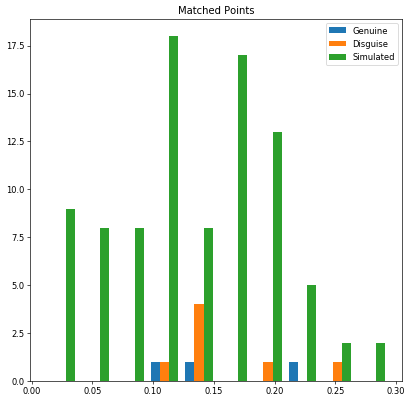

In [100]:
plot_matches(genuine_match_ans, disguise_match_ans, simulated_match_ans, threshold,'test')

In [92]:
far = []
frr = []
theta_range = np.arange(0.05, 0.25, 0.0005)
for theta in theta_range:
    gen = np.where(genuine_match_ans < theta)
    disg = np.where(disguise_match_ans < theta)
    sim = np.where(simulated_match_ans > theta)
    frr.append((gen[0].shape[0] + disg[0].shape[0]) / (genuine_match_ans.shape[0] + disguise_match_ans.shape[0]) * 100)
    far.append(sim[0].shape[0] / simulated_match_ans.shape[0] * 100)

### Error Rates on Test set

EER =  46.666666666666664


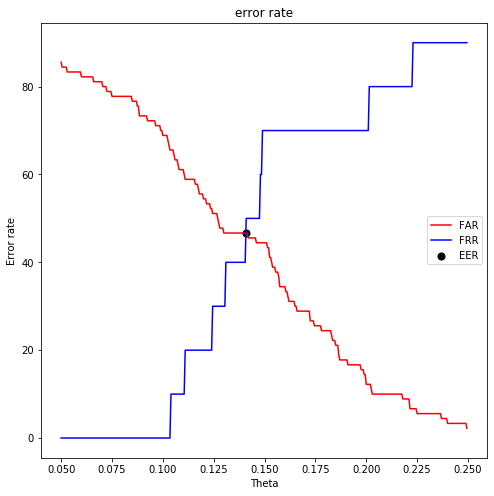

In [95]:
plot_error(theta_range, far, frr, 0.11)

### Confidence Matrix of predictions on Test set

In [49]:
eer = 0.224
gen_conf = np.where(genuine_match_ans < eer)
disg_conf = np.where(disguise_match_ans < eer)
sim_conf = np.where(simulated_match_ans > eer)
print('\t\tGenuine\tFake')
print('Genuine\t\t' + str(genuine_match_ans.shape[0] - gen_conf[0].shape[0]) + '\t' + str(gen_conf[0].shape[0]))
print('Disguise\t' + str(disguise_match_ans.shape[0] - disg_conf[0].shape[0]) + '\t' + str(disg_conf[0].shape[0]))
print('Simulated\t' + str(sim_conf[0].shape[0]) + '\t' + str(simulated_match_ans.shape[0] - sim_conf[0].shape[0]))

		Genuine	Fake
Genuine		0	3
Disguise	1	6
Simulated	6	84
